In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import matlab.engine
from sklearn.metrics import roc_auc_score
import sys
from pathlib import Path
import _pickle
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
from scipy.io import savemat

# GRIP_Package location
sys.path.append('/Users/yijwang-admin/Documents/Research/GRN_ODE_PPI/GRIP/')

# import ultility functions
from GRIP_Package.utils import *

# import GRIP functions
from GRIP_Package.GRIP import *

/Users/yijwang-admin/Documents/Research/GRN_ODE_PPI/Code
/Users/yijwang-admin/Documents/Research/GRN_ODE_PPI/GRIP/config.json
[{'PQN_Path': '/Users/yijwang-admin/Documents/Research/GRN_ODE_PPI/GRIP_Package/', 'FIMO_Path': '/Users/yijwang-admin/meme/bin/'}]
/Users/yijwang-admin/Documents/Research/GRN_ODE_PPI/GRIP_Package/


# 0. Utility Code

In [2]:
def plot_fit(t_span, Y_obs, Y_pred, b: int = 0, mask: torch.Tensor | None = None, title_prefix=""):
    """
    t_span: [T] tensor
    Y_obs, Y_pred: [T,d] or [B,T,d]
    b: which trajectory to plot if batch dimension is present
    mask: optional boolean mask [T] or [B,T]; True = observed
    """
    # to numpy
    t = t_span.detach().cpu().numpy()

    # normalize shapes to [T,d]
    if Y_obs.ndim == 3:
        Yo = Y_obs[b].detach().cpu().numpy()   # [T,d]
        Yp = Y_pred[b].detach().cpu().numpy()
        m  = None if mask is None else (mask[b].detach().cpu().numpy().astype(bool))
    else:
        Yo = Y_obs.detach().cpu().numpy()
        Yp = Y_pred.detach().cpu().numpy()
        m  = None if mask is None else (mask.detach().cpu().numpy().astype(bool))

    T, d = Yo.shape
    assert Yp.shape == (T, d), f"Shape mismatch: Y_pred {Yp.shape} vs Y_obs {Yo.shape}"

    # default mask = all observed
    if m is None:
        m = np.ones(T, dtype=bool)

    # one figure per state dimension; multiple lines on each figure
    for j in range(d):
        plt.figure()
        # observed points (masked)
        plt.plot(t[m], Yo[m, j], label="Y_obs")
        # prediction (full curve)
        plt.plot(t, Yp[:, j], label="Y_pred")
        plt.xlabel("t")
        plt.ylabel(f"state[{j}]")
        plt.title(f"{title_prefix} trajectory (dim {j})")
        plt.legend()
        plt.show()

def random_time_grid(t0, t1, n_parts=50):
    # random positive gaps
    gaps = torch.rand(n_parts)
    # normalize so they sum to (t1 - t0)
    gaps = gaps / gaps.sum() * (t1 - t0)
    # cumulative sum to get partition points
    t = t0 + torch.cat([torch.zeros(1), torch.cumsum(gaps, dim=0)])
    return t

def Sample_A(
    G=100,                       # number of genes
    Mask=None,
    density=0.08,                # fraction of nonzeros off-diagonal
    act_frac=0.6,                # fraction of activations among nonzeros
    weight_scale=0.1,            # std of coupling magnitudes
    deg_minmax=(0.2, 0.8),       # diagonal degradation range
    stabilize="diag_dom",        # "diag_dom" or "shift"
    shift_margin=0.05,           # extra margin for "shift" method
    seed=20,
    device="cpu", dtype=torch.float64
):
    #torch.manual_seed(seed)
    torch.seed()  # reseed with a fresh, random seed
    G = int(G)
    # 1) random sparse mask (no self-loops)
    mask = (torch.rand(G, G, device=device) < density)
    mask.fill_diagonal_(False)

    # 2) signs and magnitudes
    signs = torch.where(torch.rand(G, G, device=device) < act_frac, 1.0, -1.0)
    W = torch.randn(G, G, device=device, dtype=dtype) * weight_scale
    W = W * signs * mask  # off-diagonal regulations
    W.fill_diagonal_(0.0)

    # 3) diagonal degradation
    deg = torch.empty(G, device=device, dtype=dtype).uniform_(*deg_minmax)
    #print(deg)
    A = W.clone()
    A = A*Mask
    A.diagonal().copy_(-deg) 

    if stabilize == "diag_dom":
        # Enforce weak diagonal dominance
        row_sum = torch.sum(torch.abs(A), dim=1) - torch.abs(torch.diag(A))
        extra = torch.clamp(row_sum - (-torch.diag(A)) + 1e-3, min=0.0)
        # increase negativity a bit if needed
        A = A.clone()
        A[range(G), range(G)] -= extra
    elif stabilize == "shift":
        # spectral radius shift
        # estimate rho(W) via largest singular value (upper bound)
        smax = torch.linalg.svdvals(W).max()
        alpha = float(smax) + shift_margin + float(deg.min())  # ensure negative real parts
        A = W - alpha * torch.eye(G, device=device, dtype=dtype)
    else:
        raise ValueError("stabilize must be 'diag_dom' or 'shift'")

    return A

def corr_masked(A: torch.Tensor,
                B: torch.Tensor,
                mask: torch.Tensor,
                *,
                exclude_diag: bool = True,
                return_tensor: bool = False) -> float | torch.Tensor:
    """
    Pearson correlation between entries of A and B selected by `mask`.
    Optionally excludes diagonal entries.

    Args:
        A, B        : [d, d] tensors (device/dtype can differ; will be aligned to A)
        mask        : [d, d] boolean tensor indicating which entries to use
        exclude_diag: if True, remove diagonal entries from consideration
        return_tensor: if True, return a 0-dim tensor; else return Python float

    Returns:
        r (float or 0-dim tensor): Pearson correlation over masked entries.
                                   Returns NaN if <2 points or zero variance.
    """
    # Align devices/dtypes
    device, dtype = A.device, A.dtype
    A = A.detach().to(device=device, dtype=dtype)
    B = B.detach().to(device=device, dtype=dtype)
    M = mask.to(device=device, dtype=torch.bool)

    if exclude_diag:
        d = M.shape[0]
        M = M & ~torch.eye(d, dtype=torch.bool, device=device)

    # Select entries
    a = A[M].flatten()
    b = B[M].flatten()

    # Guards: need at least 2 points and non-zero std
    if a.numel() < 2:
        r = torch.tensor(float('nan'), device=device, dtype=dtype)
    else:
        a_std = a.std(unbiased=False)
        b_std = b.std(unbiased=False)
        if (a_std == 0) or (b_std == 0):
            r = torch.tensor(float('nan'), device=device, dtype=dtype)
        else:
            # Pearson r = cov / (std_a * std_b), using population moments
            cov = ((a - a.mean()) * (b - b.mean())).mean()
            r = cov / (a_std * b_std)

    return r if return_tensor else float(r)


def corr2d_overall(A: np.ndarray, B: np.ndarray, mask: np.ndarray=None, nan_policy: str="raise") -> float:
    """
    Pearson correlation between ALL paired entries of A and B (flattened).
    - mask: optional boolean array same shape as A/B to select entries.
    - nan_policy: 'raise' | 'omit' (ignore NaN pairs).
    """
    A = np.asarray(A, dtype=float)
    B = np.asarray(B, dtype=float)
    if A.shape != B.shape:
        raise ValueError(f"Shapes must match, got {A.shape} vs {B.shape}")
    
    m = np.ones_like(A, dtype=bool) if mask is None else np.asarray(mask, dtype=bool)
    if m.shape != A.shape: 
        raise ValueError("mask must have same shape as A/B")
    
    if nan_policy not in ("raise", "omit"):
        raise ValueError("nan_policy must be 'raise' or 'omit'")

    if nan_policy == "omit":
        m &= np.isfinite(A) & np.isfinite(B)
    elif np.isnan(A).any() or np.isnan(B).any():
        raise ValueError("NaNs present; set nan_policy='omit' to ignore them")

    a = A[m].ravel()
    b = B[m].ravel()
    if a.size < 2:
        return np.nan
    a_std = a.std(ddof=0)
    b_std = b.std(ddof=0)
    if a_std == 0 or b_std == 0:
        return np.nan
    cov = ((a - a.mean()) * (b - b.mean())).mean()
    return cov / (a_std * b_std)

def auroc_from_matrices(A_pre, A_true, *, mask=None):
    A_pre  = np.asarray(A_pre, dtype=float)
    A_true = np.asarray(A_true, dtype=int)

    if A_pre.shape != A_true.shape:
        raise ValueError(f"shape mismatch: {A_pre.shape} vs {A_true.shape}")

    # Optional: apply a boolean mask (e.g., exclude diagonal)
    if mask is not None:
        mask = np.asarray(mask, dtype=bool)
        A_pre  = A_pre[mask]
        A_true = A_true[mask]
    else:
        A_pre  = A_pre.ravel()
        A_true = A_true.ravel()

    # AUROC needs at least one positive and one negative
    if A_true.min() == A_true.max():
        raise ValueError("AUROC undefined: ground truth has only one class.")

    return roc_auc_score(A_true, A_pre)

def auroc_matrix_by_row(A_pre, A_true, TopK=10):
    
    auroc_rows = []
    for rr in range(len(A_true)):
        if np.sum(A_true[rr,:]) < 1:
            continue
        
        idx = np.argpartition(np.abs(A_pre[rr,:]), -TopK)[-TopK:]

        # make an array of zeros and keep only those k positions
        y = np.zeros_like(np.abs(A_pre[rr,:]))
        y[idx] = np.abs(A_pre[rr,:])[idx]
        
        auroc_tmp = roc_auc_score(A_true[rr,:], y)
        auroc_rows.extend([auroc_tmp])
        
    return auroc_rows
        


def aupr_from_matrices(A_pre, A_true, *, mask=None):
    A_pre  = np.asarray(A_pre, dtype=float)
    A_true = np.asarray(A_true, dtype=int)

    if A_pre.shape != A_true.shape:
        raise ValueError(f"shape mismatch: {A_pre.shape} vs {A_true.shape}")

    # Optional mask (e.g., exclude diagonal)
    if mask is not None:
        mask = np.asarray(mask, dtype=bool)
        A_pre  = A_pre[mask]
        A_true = A_true[mask]
    else:
        A_pre  = A_pre.ravel()
        A_true = A_true.ravel()

    # Need at least one positive and one negative
    uniq = np.unique(A_true)
    if uniq.size < 2:
        raise ValueError("AUPR undefined: ground truth has only one class.")

    # Precision–Recall curve
    precision, recall, _ = precision_recall_curve(A_true, A_pre)

    # area under PR curve (precision as a function of recall)
    aupr = auc(recall, precision)

    return float(aupr)


def aupr_from_matrices_by_row(A_pre, A_true, *, mask=None):
    A_pre  = np.asarray(A_pre, dtype=float)
    A_true = np.asarray(A_true, dtype=int)

    if A_pre.shape != A_true.shape:
        raise ValueError(f"shape mismatch: {A_pre.shape} vs {A_true.shape}")
        
    nrow, ncol = A_pre.shape
    Aupr_Rows = np.zeros(nrow)
    for i in range(nrow):
        # Optional mask (e.g., exclude diagonal)
        if mask is not None:
            mask = np.asarray(mask, dtype=bool)
            A_pre_r  = A_pre[i,mask[i,:]]
            A_true_r = A_true[i,mask[i,:]]
        else:
            A_pre_r  = A_pre[i,:].ravel()
            A_true_r = A_true[i,:].ravel()

        # Need at least one positive and one negative
        uniq = np.unique(A_true_r)
        if uniq.size < 2:
            continue
            raise ValueError("AUPR undefined: ground truth has only one class.")

        # Precision–Recall curve
        precision, recall, _ = precision_recall_curve(A_true_r, A_pre_r)

        # area under PR curve (precision as a function of recall)
        aupr = auc(recall, precision)
        
        Aupr_Rows[i] = aupr

    return float(np.mean(Aupr_Rows)), Aupr_Rows



In [3]:
class LTIExact(nn.Module):
    def __init__(self, d, mask, A=None, scale=0.1, eye_shift=0.1):
        super().__init__()
        self.d = d
        self.register_buffer('mask', mask.bool())

        I = torch.eye(d, dtype=torch.float32)
        if A is None:
            M  = torch.randn(d, d, dtype=torch.float32)
            W0 = (M - M.T) * scale - eye_shift * I   # skew-sym + negative diag
        else:
            A_init = torch.as_tensor(A, dtype=torch.float32)
            W0 = A_init * scale - eye_shift * I

        self.W = nn.Parameter(W0 * self.mask)

    @property
    def A_eff(self):
        return self.W * self.mask

    def predict_traj(self, X0: torch.Tensor, t_span: torch.Tensor) -> torch.Tensor:
        """
        X0:    [B, d]
        t_span:[B, T]  (per-sample time grid)
        returns:
            Y_pred: [B, T, d] where Y_pred[b, t] = X0[b] @ exp(A * t_span[b, t])^T
        """
        A = self.A_eff  # [d, d]

        # Ensure devices/dtypes match
        device, dtype = A.device, A.dtype
        X0    = X0.to(device=device, dtype=dtype)
        t_span = t_span.to(device=device, dtype=dtype)  # [B,T]

        # Build [B, T, d, d] of exponentials: exp( A * t_{b,t} )
        # Broadcasting: [1,1,d,d] * [B,T,1,1] -> [B,T,d,d]
        At = A.unsqueeze(0).unsqueeze(0) * t_span[..., None, None]  # [B,T,d,d]
        E  = torch.matrix_exp(At)                                   # [B,T,d,d]

        # Compute X0[b] @ E[b,t]^T for all b,t
        # [B,1,d] @ [B,T,d,d]^T -> [B,T,d]
        Y_pred = torch.einsum('bid,btdk->btk', X0[:, None, :], E.transpose(-1, -2))
        return Y_pred
    
    def forward(self, X0, t_span):
        return self.predict_traj(X0, t_span)

    
def Train_LTIExact(
    model,
    X0: torch.Tensor,
    t_span: torch.Tensor,
    Y_obs: torch.Tensor,
    *,
    loss_type: str = "mse",          # "mse" or "huber"
    huber_delta: float = 0.5,        # only used if loss_type == "huber"
    l1_lambda: float = 0.0,          # L1 reg coefficient
    l2_lambda: float = 0.0,          # L2 reg coefficient
    lr: float = 1e-2,
    epochs: int = 20001,
    print_every: int = 1000,
    device=None,
):
    """
    Train LTIExact with configurable loss and regularization.

    Args:
        model:       LTIExact module (already constructed)
        X0:          [B, d] initial states
        t_span:      [T] or [B, T] time grid(s)
        Y_obs:       [B, T, d] observed trajectories
        loss_type:   "mse" or "huber"
        huber_delta: delta parameter for Huber loss
        l1_lambda:   coefficient for L1 on masked weights
        l2_lambda:   coefficient for L2 on masked weights
        lr:          Adam learning rate
        epochs:      training epochs
        print_every: print progress every N epochs
        device:      torch.device or None (infer from model)

    Returns:
        model (trained), history dict with 'loss' and 'data_loss'
    """
    if device is None:
        device = next(model.parameters()).device

    X0     = X0.to(device)
    t_span = t_span.to(device)
    Y_obs  = Y_obs.to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    history = {"loss": [], "data_loss": []}

    for epoch in range(epochs):
        opt.zero_grad(set_to_none=True)

        Y_pred = model(X0, t_span)  # [B, T, d]

        # data loss
        if loss_type.lower() == "mse":
            data_loss = F.mse_loss(Y_pred, Y_obs)
        elif loss_type.lower() == "huber":
            data_loss = F.huber_loss(Y_pred, Y_obs, delta=huber_delta, reduction="mean")
        else:
            raise ValueError("loss_type must be 'mse' or 'huber'")

        # regularization on masked weights
        W_masked = model.W * model.mask
        reg = 0.0
        if l2_lambda > 0.0:
            reg = reg + l2_lambda * (W_masked.pow(2).sum())
        if l1_lambda > 0.0:
            reg = reg + l1_lambda * (W_masked.abs().sum())

        loss = data_loss + reg
        loss.backward()
        opt.step()

        # logs
        history["loss"].append(loss.item())
        history["data_loss"].append(data_loss.item())

        if epoch % print_every == 0 or epoch == 0:
            print(f"epoch {epoch:05d}  loss {data_loss.item():.4e}  total {loss.item():.4e}")

    return model, history



def Train_LTIExact_GroundTruth(
    model,
    X0: torch.Tensor,
    t_span: torch.Tensor,
    Y_obs: torch.Tensor,
    A_GT,
    *,
    loss_type: str = "mse",          # "mse" or "huber"
    huber_delta: float = 0.5,        # only used if loss_type == "huber"
    l1_lambda: float = 0.0,          # L1 reg coefficient
    l2_lambda: float = 0.0,          # L2 reg coefficient
    lr: float = 1e-2,
    epochs: int = 20001,
    print_every: int = 1000,
    device=None,
):
    """
    Train LTIExact with configurable loss and regularization.

    Args:
        model:       LTIExact module (already constructed)
        X0:          [B, d] initial states
        t_span:      [T] or [B, T] time grid(s)
        Y_obs:       [B, T, d] observed trajectories
        loss_type:   "mse" or "huber"
        huber_delta: delta parameter for Huber loss
        l1_lambda:   coefficient for L1 on masked weights
        l2_lambda:   coefficient for L2 on masked weights
        lr:          Adam learning rate
        epochs:      training epochs
        print_every: print progress every N epochs
        device:      torch.device or None (infer from model)

    Returns:
        model (trained), history dict with 'loss' and 'data_loss'
    """
    if device is None:
        device = next(model.parameters()).device

    X0     = X0.to(device)
    t_span = t_span.to(device)
    Y_obs  = Y_obs.to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    history = {"loss": [], "data_loss": []}

    for epoch in range(epochs):
        opt.zero_grad(set_to_none=True)

        Y_pred = model(X0, t_span)  # [B, T, d]

        # data loss
        if loss_type.lower() == "mse":
            data_loss = F.mse_loss(Y_pred, Y_obs)
        elif loss_type.lower() == "huber":
            data_loss = F.huber_loss(Y_pred, Y_obs, delta=huber_delta, reduction="mean")
        else:
            raise ValueError("loss_type must be 'mse' or 'huber'")

        # regularization on masked weights
        W_masked = model.W * model.mask
        reg = 0.0
        if l2_lambda > 0.0:
            reg = reg + l2_lambda * (W_masked.pow(2).sum())
        if l1_lambda > 0.0:
            reg = reg + l1_lambda * (W_masked.abs().sum())

        loss = data_loss + reg
        loss.backward()
        opt.step()

        # logs
        history["loss"].append(loss.item())
        history["data_loss"].append(data_loss.item())
        

        if epoch % print_every == 0 or epoch == 0:
            with torch.no_grad():  
                Aeff = np.abs(model.A_eff.detach().cpu().clone())
                aupr_all = aupr_from_matrices(Aeff, A_GT, mask = model.mask)
                aupr_row, _ = aupr_from_matrices_by_row(Aeff, A_GT, mask = model.mask)
                auroc = auroc_from_matrices(Aeff, A_GT, mask = model.mask)
                
            print(f"epoch {epoch:05d}  loss {data_loss.item():.4e}  total {loss.item():.4e} aupr_all {aupr_all:.4f}, aupr_row {aupr_row:.4f}, auroc {auroc:.4f}")

    return model, history


def Train_LTIExact_TFCollab(
    model,
    X0: torch.Tensor,
    t_span: torch.Tensor,
    Y_obs: torch.Tensor,
    DisMat: np.array,
    TFIndx: np.ndarray,
    A_true_binary: np.ndarray,
    Mask_auroc,
    *,
    loss_type: str = "mse",          # "mse" or "huber"
    huber_delta: float = 0.5,        # only used if loss_type == "huber"
    l2_lambda: float = 0.0,          # L2 reg coefficient
    rho: float = 1.0,
    Dis_lambda: float = 1.0,
    TopK: int = 5,
    lr: float = 1e-2,
    epochs: int = 20001,
    proximal_every: int = 4000,
    print_every: int = 1000,
    device=None,
):
    """
    Train LTIExact with configurable loss and regularization.

    Args:
        model:       LTIExact module (already constructed)
        X0:          [B, d] initial states
        t_span:      [T] or [B, T] time grid(s)
        Y_obs:       [B, T, d] observed trajectories
        loss_type:   "mse" or "huber"
        huber_delta: delta parameter for Huber loss
        l1_lambda:   coefficient for L1 on masked weights
        l2_lambda:   coefficient for L2 on masked weights
        lr:          Adam learning rate
        epochs:      training epochs
        print_every: print progress every N epochs
        device:      torch.device or None (infer from model)

    Returns:
        model (trained), history dict with 'loss' and 'data_loss'
    """
    if device is None:
        device = next(model.parameters()).device

    X0     = X0.to(device)
    t_span = t_span.to(device)
    Y_obs  = Y_obs.to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    history = {"loss": [], "data_loss": []}

    for epoch in range(epochs):
        opt.zero_grad(set_to_none=True)

        Y_pred = model(X0, t_span)  # [B, T, d]

        # data loss
        if loss_type.lower() == "mse":
            data_loss = F.mse_loss(Y_pred, Y_obs)
        elif loss_type.lower() == "huber":
            data_loss = F.huber_loss(Y_pred, Y_obs, delta=huber_delta, reduction="mean")
        else:
            raise ValueError("loss_type must be 'mse' or 'huber'")

        # regularization on masked weights
        W_masked = model.W * model.mask
        reg = 0.0
        if l2_lambda > 0.0:
            reg = reg + l2_lambda * (W_masked.pow(2).sum())

        #print(">>", data_loss, reg)
        loss = data_loss + reg
        loss.backward()
        opt.step()
        
        # proximal to consider TF collaboration
        if (epoch + 1) % proximal_every == 0:
            #print("++++++++++++++++++")
            lr = opt.param_groups[0]['lr']  # single LR
            with torch.no_grad():
                W = model.W
                #print("Old:", W.numpy())
                Rho = rho# * lr
                Lam = Dis_lambda# * lr
                W_new, Auroc_row = proximal_tf_collaborate_TFIndx_AUROC(W, A_true_binary, DisMat, TFIndx, TopK, Rho, Lam)
                #print("New:", W_new.numpy)
                W.copy_(W_new)              # write back once
                print("Auroc_row", np.mean(Auroc_row))
        
        
        # logs
        history["loss"].append(loss.item())
        history["data_loss"].append(data_loss.item())

        if epoch % print_every == 0 or epoch == 0:
            auroc = auroc_from_matrices(np.abs(model.A_eff.clone().detach().numpy()), A_true_binary, mask = Mask_auroc)
            auroc_row = auroc_matrix_by_row(np.abs(model.A_eff.clone().detach().numpy()), A_true_binary, TopK)
            print(f"epoch {epoch:05d}  loss {data_loss.item():.4e}  total {loss.item():.4e} AUROC {auroc:.5f} AUROC (row mean) {np.mean(auroc_row): 0.5f}")

    return model, history


In [4]:
def run_pqn_l0gl(y_train, SimMat,
    rho, Lambda, TopK,
    *,
    max_iter: int = 400,
    verbose: int = -1,
    obj_fn = None,          # defaults to L0GL_PPI_Obj
    proj_fn = None,         # defaults to ProjCSimplex_Gurobi_LB
    solver = None           # defaults to minConF_PQN
):
    """
    Wraps the PQN call:
        uout, obj, _ = minConF_PQN(funObj_PPI, uSimplex, funProj_GL_LB, options)

    Parameters
    ----------
    y_train, SimMat : arrays/matrices for the objective
    rho, Lambda              : regularization/scalar params for the objective
    TopK                     : simplex projection parameter
    max_iter, verbose        : options for the solver
    obj_fn                   : callable(w, X_train, y_train, SimMat, rho, Lambda)
    proj_fn                  : callable(w, TopK) -> projected w
    solver                   : callable(funObj, u0, funProj, options) -> (uout, obj, info)

    Returns
    -------
    uout, obj, info
    """
    # Default to your existing functions if not provided
    if obj_fn is None:
        obj_fn = L0GL_PPI_Obj
    if proj_fn is None:
        proj_fn = ProjCSimplex_Gurobi_LB
    if solver is None:
        solver = minConF_PQN
        
    u_init = np.ones((len(y_train), 1)) * (1 / len(y_train))
    X_train = np.eye(len(y_train))

    # Build the closures expected by the solver
    funObj_PPI    = lambda w: obj_fn(w, X_train, y_train, SimMat, rho, Lambda)
    funProj_GL_LB = lambda w: proj_fn(w, TopK)

    options = {'maxIter': max_iter, 'verbose': verbose}

    uout, obj, info = solver(funObj_PPI, u_init, funProj_GL_LB, options)
    return uout.ravel(), obj, info

def topk_idx(a, k):
    a = np.asarray(a)
    k = int(k)
    k = max(0, min(k, a.size))        # clamp 0..n
    if k == 0:
        return np.array([], dtype=int)
    idx = np.argpartition(a, -k)[-k:]  # unsorted top-k indices
    # sort them by value (largest → smallest)
    return idx[np.argsort(a[idx])[::-1]]

# ||y-u||_2^2 + Lam ||u||_0^T Dis ||u||_0
def obj_eval(input_y, select_id, DisMat, Lam):
    # obj part 1
    y_rest = np.delete(input_y, select_id) 
    obj_part1 = np.linalg.norm(y_rest)**2
    
    # obj part 2
    u_int = np.zeros(len(input_y))
    u_int[select_id] = 1.0
    obj_part2 = u_int @ (DisMat @ u_int)
    
    #print("obj1:", obj_part1, "obj2:", obj_part2)
    
    return obj_part1 + Lam*obj_part2
    
    
def select_idx(input_y, input_u, DisMat, Lam):

    idx = np.where(input_u>=0.1)[0]#flatnonzero(input_u)              # nonzero indices
    vals = input_u[idx]
    order = np.argsort(vals)            # ascending
    idx_sorted = idx[order]
    #print(input_u)
    #print(idx_sorted)
    
    objbest = np.inf#1000000
    indbest = []
    for i in range(len(idx_sorted)):
        ind_tmp = idx_sorted[i:]
        objt = obj_eval(input_y, ind_tmp, DisMat, Lam)
        #print(ind_tmp, objt)
        if objt < objbest:
            objbest = objt
            indbest = ind_tmp
    
    return indbest
    

def proximal_tf_collaborate(A: torch.Tensor, DisMat: np.ndarray, NumTF: int, TopK: int, Rho: float, Lam: float):
    Aclone = A.clone().detach().numpy()
    A_ = A.detach().numpy()
    nr, nc = A_.shape
    vec0 = np.zeros(NumTF)
    for rr in range(nr):
        y = A_[rr,-NumTF:] / np.mean(A_[rr,-NumTF:])
        print("->", rr, end=" ")
        print(Rho, Lam)
        u, _, _ = run_pqn_l0gl(y[:,None], DisMat, Rho, Lam, TopK, max_iter=100, verbose= -1, obj_fn = L0GL_PPI_Obj,  proj_fn = ProjCSimplex_Gurobi_LB, solver=minConF_PQN)
        print(u)
        print(np.sum(u), TopK)
        TopkID = select_idx(y, u, DisMat, Lam)#np.nonzero(u)[0]#topk_idx(u, TopK)
        if len(TopkID) > TopK:
            TopkID = TopkID[0:TopK]
        print("Non 0 id:", TopkID, "len:" ,len(TopkID))
        u_back = np.zeros(NumTF)#vec0
        print("u_back init:", u_back)
        u_back[TopkID] = y[TopkID] #/ (1.+Rho)
        print("New:", u_back)
        
        
        A_[rr,-NumTF:] = u_back * np.mean(A_[rr,-NumTF:])
    #print()
    A_[np.diag_indices_from(A_)] = np.diag(Aclone)
    A_ = torch.tensor(A_, dtype=torch.float32)
    return A_



def proximal_tf_collaborate_TFIndx(A: torch.Tensor, DisMat: np.ndarray, TFIndx: np.ndarray, TopK: int, Rho: float, Lam: float):
    Aclone = A.clone().detach().numpy()
    A_ = A.detach().numpy()
    nr, nc = A_.shape
    for rr in range(nr):
        y = A_[rr,TFIndx] / np.mean(A_[rr,TFIndx])
        print("->", rr, end=" ")
        print(Rho, Lam)
        u, _, _ = run_pqn_l0gl(y[:,None], DisMat, Rho, Lam, TopK, max_iter=100, verbose= -1, obj_fn = L0GL_PPI_Obj,  proj_fn = ProjCSimplex_Gurobi_LB, solver=minConF_PQN)
        print(u)
        print(np.sum(u), TopK)
        TopkID = select_idx(y, u, DisMat, Lam)#np.nonzero(u)[0]#topk_idx(u, TopK)
        if len(TopkID) > TopK:
            TopkID = TopkID[-TopK:]
        TopkID_sort = np.sort(TopkID)    
        print("Non 0 id:", TopkID_sort, "len:" ,len(TopkID_sort))
        u_back = np.zeros(len(TFIndx))#vec0
        print("u_back init:", u_back)
        u_back[TopkID_sort] = y[TopkID_sort] #/ (1.+Rho)
        print("New:", u_back)
        
        
        A_[rr,TFIndx] = u_back * np.mean(A_[rr,TFIndx])
    #print()
    A_[np.diag_indices_from(A_)] = np.diag(Aclone)
    A_ = torch.tensor(A_, dtype=torch.float32)
    return A_

def proximal_tf_collaborate_TFIndx_AUROC(A: torch.Tensor, Atrue: np.ndarray, DisMat: np.ndarray, TFIndx: np.ndarray, TopK: int, Rho: float, Lam: float):
    Aclone = A.clone().detach().numpy()
    A_ = A.clone().detach().numpy()
    nr, nc = A_.shape
    
    AUROC_Rows = []
    for rr in range(nr):
        #if np.sum(Atrue[rr,:]) < 1:
        #    print("->", rr, "No AUROC!", end = "|")
        #    continue
        y = A_[rr,TFIndx] / np.mean(A_[rr,TFIndx])
        print("->", rr, end = " ")
        GT_Idx = np.where(Atrue[rr,:]>0)[0]
        #print("GT :", GT_Idx, len(GT_Idx))
        #print(Rho, Lam)
        u, _, _ = run_pqn_l0gl(y[:,None], DisMat, Rho, Lam, TopK, max_iter=100, verbose= -1, obj_fn = L0GL_PPI_Obj,  proj_fn = ProjCSimplex_Gurobi_LB, solver=minConF_PQN)
        #print(u)
        #print(np.sum(u), TopK)
        TopkID = select_idx(y, u, DisMat, Lam)#np.nonzero(u)[0]#topk_idx(u, TopK)
        if len(TopkID) > TopK:
            TopkID = TopkID[-TopK:]
        #print("Non 0 id:", TopkID, "len:" ,len(TopkID))
        TopkID_sort = np.sort(TopkID)    
        #print("Non 0 id:", TopkID_sort, "len:" ,len(TopkID_sort))
        #print("Pre:", TopkID[::-1], len(TopkID_sort))
        
        u_back = np.zeros(len(TFIndx))#vec0
        #print("u_back init:", u_back)
        u_back[TopkID_sort] = y[TopkID_sort] #/ (1.+Rho)
        
        Overlap_Pre_GT = list(set(TopkID_sort) & set(GT_Idx))
        #print("Overlap:", Overlap_Pre_GT, len(Overlap_Pre_GT))
        
        
        A_[rr,TFIndx] = u_back * np.mean(A_[rr,TFIndx])
        if np.sum(Atrue[rr,:]) >= 1:
            auroctmp = roc_auc_score(Atrue[rr,:], np.abs(A_[rr,:]))
            print("AUROC:", auroctmp, end = "|")
            AUROC_Rows.extend([auroctmp])
        else:
            print("No AUROC!")
    #print()
    A_[np.diag_indices_from(A_)] = np.diag(Aclone)
    A_ = torch.tensor(A_, dtype=torch.float32)
    return A_, AUROC_Rows

In [5]:
import os
import subprocess
import numpy as np

def run_scode_from_numpy(
    X_sim: np.ndarray,          # shape [G, C]  (genes x cells)
    t_span: np.ndarray,         # shape [C]     (one time per cell)
    out_dir: str,
    *,
    model_params: dict | None = None,
    scode_r_path: str = "../SCODE/scode/SCODE.R",
    rscript_bin: str = "Rscript",
    work_dir: str = "../Data/datasim",   # where input txts are written
    save_x0: bool = False,
    X0_SCODE: np.ndarray | None = None,
) -> np.ndarray:
    """
    Save inputs, call SCODE (R), and load A_SCODE as a NumPy array.

    Parameters
    ----------
    X_sim : np.ndarray
        Expression matrix [G, C] (genes x cells).
    t_span : np.ndarray
        Time vector of length C.
    out_dir : str
        Output directory where SCODE writes A.txt.
    model_params : dict
        Keys: 'G', 'C', 'd', 'num_iterations'. Defaults auto-filled from X_sim and sensible values.
    scode_r_path : str
        Path to SCODE.R
    rscript_bin : str
        Rscript executable (default 'Rscript').
    work_dir : str
        Directory to write 'X_sim.txt' and 'time_sim.txt'.
    save_x0 : bool
        If True, also writes 'x0.txt' from X0_SCODE.

    Returns
    -------
    A_SCODE : np.ndarray
        The SCODE inferred matrix loaded from A.txt.
    """
    # sanitize inputs
    X_sim = np.asarray(X_sim, dtype=float)
    t_span = np.asarray(t_span, dtype=float).reshape(-1)
    #print(X_sim)
    #print(t_span)

    G, C = X_sim.shape
    if t_span.shape[0] != C:
        raise ValueError(f"t_span length {t_span.shape[0]} must equal number of cells C={C} in X_sim")

    os.makedirs(work_dir, exist_ok=True)
    os.makedirs(out_dir, exist_ok=True)

    # file paths
    x_path  = os.path.join(work_dir, "X_sim.txt")
    t_path  = os.path.join(work_dir, "time_sim.txt")

    # write expression
    np.savetxt(x_path, X_sim, delimiter="\t")
    np.savetxt(t_path, t_span, delimiter="\t")

    # SCODE time file: 2 columns -> (cell_index starting at 1, time)
    cell_idx = np.arange(1, C + 1, dtype=float).reshape(-1, 1)
    np.savetxt(t_path, np.hstack([cell_idx, t_span.reshape(-1, 1)]), delimiter="\t")

    # optional x0
    if save_x0:
        if X0_SCODE is None:
            raise ValueError("save_x0=True but X0_SCODE=None")
        np.savetxt(x0_path, np.asarray(X0_SCODE, dtype=float), delimiter="\t")

    # default params (override with model_params if provided)
    params = dict(G=G, C=C, d=4, num_iterations=500)
    if model_params:
        params.update(model_params)

    # build and run command
    cmd = [
        rscript_bin,
        scode_r_path,
        x_path,
        t_path,
        out_dir,
        str(params["G"]),
        str(params["d"]),
        str(params["C"]),
        str(params["num_iterations"]),
    ]
    result = subprocess.run(cmd, capture_output=True, text=True)
    if result.returncode != 0:
        raise RuntimeError(
            "SCODE failed:\n"
            f"CMD: {' '.join(cmd)}\n"
            f"STDOUT:\n{result.stdout}\n"
            f"STDERR:\n{result.stderr}"
        )

    # load A.txt
    a_path = os.path.join(out_dir, "A.txt")
    if not os.path.exists(a_path):
        raise FileNotFoundError(f"SCODE did not produce {a_path}")
    A_SCODE = np.loadtxt(a_path, delimiter="\t")
    return A_SCODE,result

In [63]:
# load in data
GeneExp = np.loadtxt("../GRISLI-master/SCODE-master/data1/datamatrix.txt")
Time = np.loadtxt("../GRISLI-master/SCODE-master/data1/pseudotime.txt")

# load in ground truth
A_true = np.loadtxt("../GRISLI-master/SCODE-master/data1/A.txt")
TFs = np.loadtxt("../GRISLI-master/SCODE-master/data1/tf.txt", dtype=str)           # -> numpy array of strings
TFs = TFs.tolist()  

In [64]:
# load in ground truth
A_true = np.loadtxt("../GRISLI-master/SCODE-master/data1/A.txt")
TFs = np.loadtxt("../GRISLI-master/SCODE-master/data1/tf.txt", dtype=str)           # -> numpy array of strings
TFs = TFs.tolist()  
A_true_df = pd.DataFrame(A_true, index=TFs, columns=TFs)

In [65]:
A_true_df

,SOX2,ESRRB,UTF1,EPAS1,FOXQ1,KLF2,GATA4,SOX17,NR0B1,ZFP42,...,ZBTB44,ELF2,ETS1,JUN,BMYC,POU4F2,TFEB,DDIT3,SALL4,ZFP462
SOX2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ESRRB,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
UTF1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EPAS1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
FOXQ1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
POU4F2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TFEB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DDIT3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
SALL4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
# Reorder the data based on the time increasing order
perm = np.argsort(Time)          # indices that sort Time ascending
Time_sorted    = Time[perm]
GeneExp_sorted = GeneExp[:, perm]
GeneExp_sorted_T = GeneExp_sorted.T

In [67]:
t_span = torch.tensor(Time_sorted[None,:], dtype=torch.float32)
Y_obs = torch.tensor(GeneExp_sorted_T[None,:,:], dtype=torch.float32)
X0 = Y_obs[0,0,:][None,:]

d, B, T = 100, 1, 456

Mask = torch.tensor(np.ones((d,d)), dtype=torch.bool)

In [70]:
Time.shape

(456,)

# 1. Load in Data

In [74]:
# load in data
GeneExp = np.loadtxt("../GRISLI-master/SCODE-master/data1/datamatrix_ordered_smooth_5.txt")
Time = np.loadtxt("../GRISLI-master/SCODE-master/data1/pseudotime_ordered.txt")

# load in ground truth
A_true = np.loadtxt("../GRISLI-master/SCODE-master/data1/A.txt")

In [75]:
# Reorder the data based on the time increasing order
perm = np.argsort(Time)          # indices that sort Time ascending
Time_sorted    = Time[perm]
GeneExp_sorted = GeneExp[:, perm]
GeneExp_sorted_T = GeneExp_sorted.T

In [76]:
t_span = torch.tensor(Time_sorted[None,:], dtype=torch.float32)
Y_obs = torch.tensor(GeneExp_sorted_T[None,:,:], dtype=torch.float32)
X0 = Y_obs[0,0,:][None,:]

d, B, T = 100, 1, 456

Mask = torch.tensor(np.ones((d,d)), dtype=torch.bool)

In [77]:
t_span.shape, Y_obs.shape, X0.shape, t_span[0,-1]

(torch.Size([1, 456]),
 torch.Size([1, 456, 100]),
 torch.Size([1, 100]),
 tensor(1.))

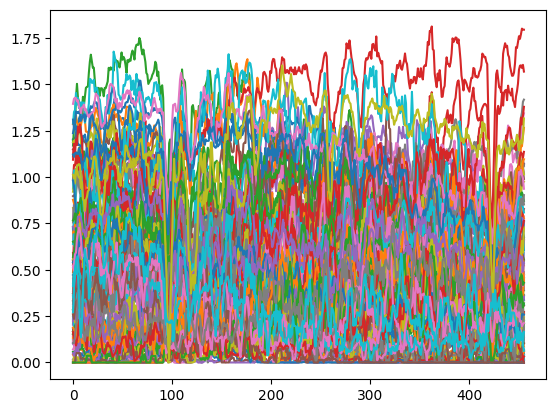

In [78]:
Y_obs_np = Y_obs[0,:,:].detach().cpu().numpy()

n_rows, n_cols = Y_obs_np.shape
x_axis = range(n_rows)    # row indices: 0 .. n_rows-1

plt.figure()

for j in range(n_cols):
    plt.plot(x_axis, Y_obs_np[:, j], label=f'col {j}')

## Our methods

In [79]:
class LTIExact_Steady(nn.Module):
    def __init__(self, d, mask, A=None, X_star_init=None, scale=0.1, eye_shift=0.1):
        super().__init__()
        self.d = d
        self.register_buffer('mask', mask.bool())

        I = torch.eye(d, dtype=torch.float32)
        if A is None:
            M  = torch.randn(d, d, dtype=torch.float32)
            W0 = (M - M.T) * scale - eye_shift * I   # skew-sym + negative diag
        else:
            A_init = torch.as_tensor(A, dtype=torch.float32)
            W0 = A_init * scale - eye_shift * I

        self.W = nn.Parameter(W0 * self.mask)         # learns A
        
        # --- new: initialize x_star ---
        if X_star_init is None:
            X_star0 = torch.zeros(B, d, dtype=torch.float32)
        else:
            X_star0 = torch.as_tensor(X_star_init, dtype=torch.float32)

        self.X_star = nn.Parameter(X_star0)                # learns x_star
        

    @property
    def A_eff(self):
        return self.W * self.mask

    def predict_traj(self, X0: torch.Tensor, t_span: torch.Tensor) -> torch.Tensor:
        """
        X0:    [B, d]
        t_span:[B, T]
        returns:
            Y_pred: [B, T, d]
        """
        A = self.A_eff                                # [d, d]
        device, dtype = A.device, A.dtype
        X_star = self.X_star

        X0     = X0.to(device=device, dtype=dtype)    # [B,d]
        t_span = t_span.to(device=device, dtype=dtype)# [B,T]
        #x_star = self.x_star.to(device=device, dtype=dtype)  # [d]

        # Build exp(A t) as before
        At = A.unsqueeze(0).unsqueeze(0) * t_span[..., None, None]  # [B,T,d,d]
        E  = torch.matrix_exp(At)                                    # [B,T,d,d]

        # Closed-form: x(t) = x_star + exp(A t) (x0 - x_star)
        X0_shift   = X0 - X_star                     # [B,d]
        Y_centered = torch.einsum(
            'bid,btdk->btk',
            X0_shift[:, None, :],                   # [B,1,d]
            E.transpose(-1, -2)                     # [B,T,d,d]
        )                                            # [B,T,d]
        Y_pred = Y_centered + X_star                # broadcast over [B,T,d]

        return Y_pred

    def forward(self, X0, t_span):
        return self.predict_traj(X0, t_span)
    

    
def Train_LTIExact_Steady_l1_l2_AUROC(
    model,
    X0: torch.Tensor,
    t_span: torch.Tensor,
    Y_obs: torch.Tensor,
    A_true,
    Mask_auroc,
    *,
    loss_type: str = "mse",          # "mse" or "huber"
    huber_delta: float = 0.5,        # only used if loss_type == "huber"
    l1_lambda: float = 0.0,          # L1 reg coefficient
    l2_lambda: float = 0.0,          # L2 reg coefficient
    lr: float = 1e-2,
    epochs: int = 20001,
    print_every: int = 1000,
    device=None,
):
    """
    Train LTIExact with configurable loss and regularization.

    Args:
        model:       LTIExact module (already constructed)
        X0:          [B, d] initial states
        t_span:      [T] or [B, T] time grid(s)
        Y_obs:       [B, T, d] observed trajectories
        loss_type:   "mse" or "huber"
        huber_delta: delta parameter for Huber loss
        l1_lambda:   coefficient for L1 on masked weights
        l2_lambda:   coefficient for L2 on masked weights
        lr:          Adam learning rate
        epochs:      training epochs
        print_every: print progress every N epochs
        device:      torch.device or None (infer from model)

    Returns:
        model (trained), history dict with 'loss' and 'data_loss'
    """
    if device is None:
        device = next(model.parameters()).device

    X0     = X0.to(device)
    t_span = t_span.to(device)
    Y_obs  = Y_obs.to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    history = {"loss": [], "data_loss": []}

    for epoch in range(epochs):
        opt.zero_grad(set_to_none=True)

        Y_pred = model(X0, t_span)  # [B, T, d]

        # data loss
        if loss_type.lower() == "mse":
            data_loss = F.mse_loss(Y_pred, Y_obs)
        elif loss_type.lower() == "huber":
            data_loss = F.huber_loss(Y_pred, Y_obs, delta=huber_delta, reduction="mean")
        else:
            raise ValueError("loss_type must be 'mse' or 'huber'")

        # regularization on masked weights
        W_masked = model.W * model.mask
        reg = 0.0
        if l2_lambda > 0.0:
            reg = reg + l2_lambda * (W_masked.pow(2).sum())
        if l1_lambda > 0.0:
            reg = reg + l1_lambda * (W_masked.abs().sum())

        loss = data_loss + reg
        loss.backward()
        opt.step()

        # logs
        history["loss"].append(loss.item())
        history["data_loss"].append(data_loss.item())

        if epoch % print_every == 0 or epoch == 0:
            auroc = auroc_from_matrices(np.abs(model.A_eff.clone().detach().numpy()), A_true, mask = Mask_auroc)
            print(f"epoch {epoch:05d}  loss {data_loss.item():.4e}  total {loss.item():.4e} auroc {auroc: .5f}")

    return model, history

In [120]:
# pick a device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#A_true_binary = np.where(np.abs(A_true)*Maskr>0, 1, 0)
X_Steady_Obs = Y_obs[:,-1,:].clone()

model = LTIExact_Steady(d, Mask, A=0, X_star_init = X_Steady_Obs).to(device)

model, hist = Train_LTIExact_Steady_l1_l2_AUROC(
    model,
    X0=X0,
    t_span=t_span,          # [T] or [B,T]
    Y_obs=Y_obs,
    A_true = A_true,
    Mask_auroc = Mask,
    loss_type="huber",      # or "mse"
    huber_delta=1.,
    l1_lambda=0,
    l2_lambda=0,
    lr=1e-4,
    epochs=31,
    print_every=10,
    device=device,
)

epoch 00000  loss 9.4057e-02  total 9.4057e-02 auroc  0.59038
epoch 00010  loss 8.4680e-02  total 8.4680e-02 auroc  0.60509
epoch 00020  loss 7.6793e-02  total 7.6794e-02 auroc  0.60778
epoch 00030  loss 7.0217e-02  total 7.0217e-02 auroc  0.61111


In [121]:
A_ours = model.A_eff.detach().numpy()

AUROC_Row_ours = auroc_matrix_by_row(A_ours, A_true, TopK=100)
    